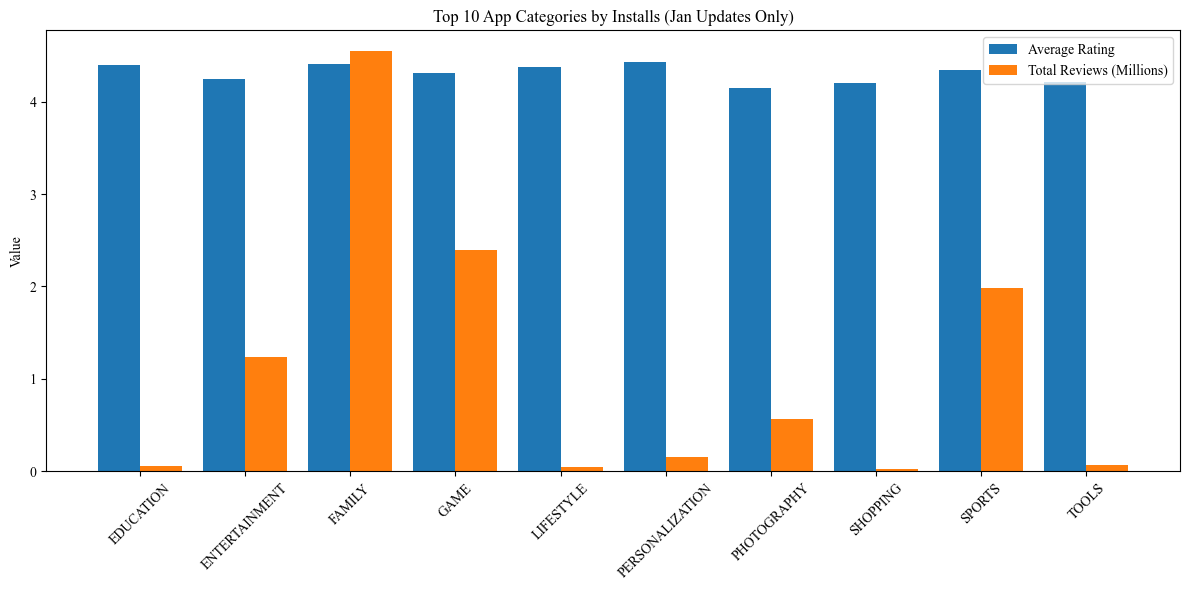

In [7]:
#task1

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import pytz

# ==============================
# SET FONT: TIMES NEW ROMAN
# ==============================
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# ==============================
# TIME CHECK (3 PM – 5 PM IST)
# ==============================
ist = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(ist).time()

start_time = datetime.strptime("13:00", "%H:%M").time()
end_time = datetime.strptime("20:00", "%H:%M").time()

if not (start_time <= current_time <= end_time):
    print("⛔ Graph available only between 3 PM and 5 PM IST")

else:
    # ==============================
    # SAFE DATA CLEANING
    # ==============================

    df['Installs'] = (
        df['Installs']
        .astype(str)
        .str.replace('[+,]', '', regex=True)
        .astype(float)
    )

    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

    df['Size'] = (
        df['Size']
        .astype(str)
        .str.replace('M', '', regex=False)
        .str.replace('k', '', regex=False)
    )
    df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

    # ==============================
    # APPLY FILTERS
    # ==============================
    df = df[
        (df['Rating'] >= 4.0) &
        (df['Size'] >= 10) &
        (df['Last Updated'].dt.month == 1)
    ]

    # ==============================
    # TOP 10 CATEGORIES BY INSTALLS
    # ==============================
    top_categories = (
        df.groupby('Category')['Installs']
        .sum()
        .sort_values(ascending=False)
        .head(10)
        .index
    )

    df_top = df[df['Category'].isin(top_categories)]

    # ==============================
    # AGGREGATION
    # ==============================
    summary = df_top.groupby('Category').agg(
        Avg_Rating=('Rating', 'mean'),
        Total_Reviews=('Reviews', 'sum')
    ).reset_index()

    # ==============================
    # GROUPED BAR CHART
    # ==============================
    x = np.arange(len(summary))

    plt.figure(figsize=(12, 6))

    plt.bar(x, summary['Avg_Rating'], width=0.4, label='Average Rating')
    plt.bar(
        x + 0.4,
        summary['Total_Reviews'] / 1e6,
        width=0.4,
        label='Total Reviews (Millions)'
    )

    plt.xticks(x + 0.2, summary['Category'], rotation=45)
    plt.ylabel("Value")
    plt.title("Top 10 App Categories by Installs (Jan Updates Only)")
    plt.legend()
    plt.tight_layout()
    plt.show()


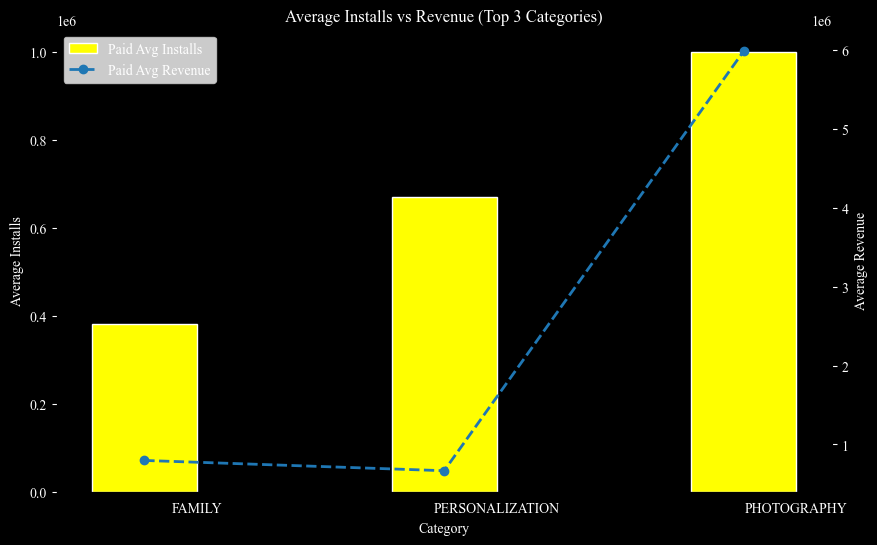

In [11]:
#task 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import re

# Set font to Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'

# -------------------------------
# 1. TIME CHECK (1 PM – 2 PM IST)
# -------------------------------
ist = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(ist)

if 13 <= current_time.hour < 20:

    # -------------------------------
    # 2. LOAD DATA
    # -------------------------------
    df = pd.read_csv("Play Store Data.csv")

    # -------------------------------
    # 3. DATA CLEANING
    # -------------------------------

    # Clean Installs column
    df['Installs'] = (
        df['Installs']
        .astype(str)
        .str.replace(r'[+,]', '', regex=True)
    )
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

    # Clean Price column
    df['Price'] = (
        df['Price']
        .astype(str)
        .str.replace('$', '', regex=False)
    )
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

    # Convert Size to MB
    def convert_size(size):
        if pd.isna(size):
            return None
        size = str(size)
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'k' in size:
            return float(size.replace('k', '')) / 1024
        else:
            return None

    df['Size_MB'] = df['Size'].apply(convert_size)

    # Extract Android version
    def extract_android_version(ver):
        if pd.isna(ver):
            return None
        match = re.search(r'(\d+\.?\d*)', str(ver))
        return float(match.group(1)) if match else None

    df['Android_Version'] = df['Android Ver'].apply(extract_android_version)

    # App name length
    df['App_Name_Length'] = df['App'].astype(str).apply(len)

    # -------------------------------
    # 4. CALCULATE REVENUE
    # -------------------------------
    df['Revenue'] = df['Price'] * df['Installs']

    # -------------------------------
    # 5. APPLY FILTERS
    # -------------------------------
    filtered = df[
        (df['Installs'] >= 10000) &
        (df['Revenue'] >= 10000) &
        (df['Android_Version'] > 4.0) &
        (df['Size_MB'] > 15) &
        (df['Content Rating'] == 'Everyone') &
        (df['App_Name_Length'] <= 30)
    ]

    # -------------------------------
    # 6. TOP 3 CATEGORIES
    # -------------------------------
    top_categories = (
        filtered.groupby('Category')['Installs']
        .sum()
        .sort_values(ascending=False)
        .head(3)
        .index
    )

    top_df = filtered[filtered['Category'].isin(top_categories)]

    # -------------------------------
    # 7. AGGREGATE DATA
    # -------------------------------
    summary = (
        top_df.groupby(['Category', 'Type'])
        .agg(
            Avg_Installs=('Installs', 'mean'),
            Avg_Revenue=('Revenue', 'mean')
        )
        .reset_index()
    )

    pivot_installs = summary.pivot(index='Category', columns='Type', values='Avg_Installs')
    pivot_revenue = summary.pivot(index='Category', columns='Type', values='Avg_Revenue')

    categories = pivot_installs.index.tolist()
    x = range(len(categories))
    bar_width = 0.35

    # -------------------------------
    # 8. DUAL-AXIS CHART
    # -------------------------------
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Set black backgrounds
    fig.patch.set_facecolor('black')
    ax1.set_facecolor('black')

    # Bars for installs (yellow)
    for i, app_type in enumerate(pivot_installs.columns):
        ax1.bar(
            [pos + i * bar_width for pos in x],
            pivot_installs[app_type],
            width=bar_width,
            color='yellow',
            edgecolor='white',
            label=f"{app_type} Avg Installs"
        )

    ax1.set_ylabel("Average Installs", color='white')
    ax1.set_xlabel("Category", color='white')
    ax1.set_xticks([pos + bar_width / 2 for pos in x])
    ax1.set_xticklabels(categories, color='white')

    ax1.tick_params(axis='y', colors='white')

    # Line for revenue
    ax2 = ax1.twinx()
    ax2.set_facecolor('black')

    for app_type in pivot_revenue.columns:
        ax2.plot(
            x,
            pivot_revenue[app_type],
            marker='o',
            linestyle='--',
            linewidth=2,
            label=f"{app_type} Avg Revenue"
        )

    ax2.set_ylabel("Average Revenue", color='white')
    ax2.tick_params(axis='y', colors='white')

    # Title
    plt.title("Average Installs vs Revenue (Top 3 Categories)", color='white')

    # Combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    legend = ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    for text in legend.get_texts():
        text.set_color("white")

    plt.show()

else:
    print("Chart is available only between 1 PM and 2 PM IST.")


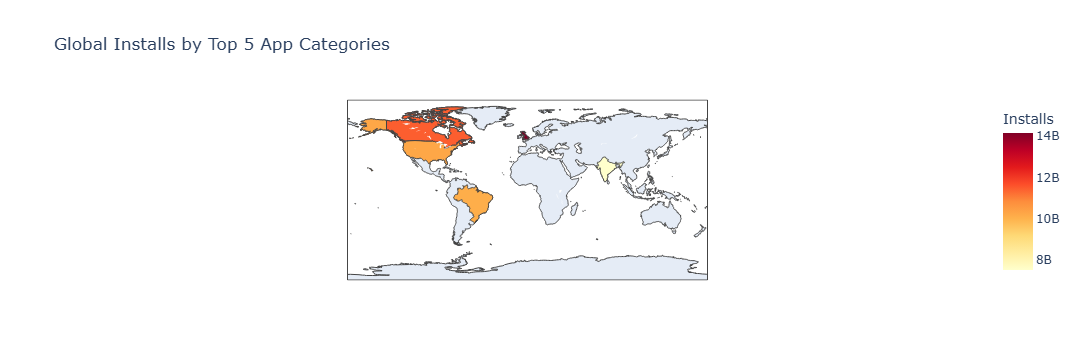

In [9]:
#task 3

import pandas as pd
import plotly.express as px
from datetime import datetime
import pytz

# -------------------------------
# 1. TIME CHECK (6 PM – 8 PM IST)
# -------------------------------
ist = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(ist)

if 13 <= current_time.hour < 20:

    # -------------------------------
    # 2. LOAD DATA
    # -------------------------------
    df = pd.read_csv("Play Store Data.csv")

    # Clean Installs column
    df['Installs'] = (
        df['Installs']
        .astype(str)
        .str.replace(r'[+,]', '', regex=True)
    )
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')
    df = df.dropna(subset=['Installs'])

    # -------------------------------
    # 3. EXCLUDE CATEGORIES
    # -------------------------------
    df = df[~df['Category'].str.startswith(('A', 'C', 'G', 'S'))]

    # -------------------------------
    # 4. TOP 5 CATEGORIES
    # -------------------------------
    top_categories = (
        df.groupby('Category')['Installs']
        .sum()
        .sort_values(ascending=False)
        .head(5)
        .index
    )

    filtered = df[df['Category'].isin(top_categories)]

    # Aggregate installs
    category_installs = (
        filtered.groupby('Category')['Installs']
        .sum()
        .reset_index()
    )

    # Highlight flag
    category_installs['Highlight'] = category_installs['Installs'] > 1_000_000
    category_installs['Highlight_Label'] = category_installs['Highlight'].map(
        {True: "Above 1M Installs", False: "Below 1M Installs"}
    )

    # Map categories to countries (for visualization only)
    country_map = {
        category_installs['Category'].iloc[0]: 'USA',
        category_installs['Category'].iloc[1]: 'IND',
        category_installs['Category'].iloc[2]: 'BRA',
        category_installs['Category'].iloc[3]: 'GBR',
        category_installs['Category'].iloc[4]: 'CAN',
    }

    category_installs['Country'] = category_installs['Category'].map(country_map)

    # -------------------------------
    # 5. CHOROPLETH MAP
    # -------------------------------
    fig = px.choropleth(
        category_installs,
        locations="Country",
        color="Installs",
        hover_name="Category",
        hover_data={
            "Installs": True,
            "Highlight_Label": True,
            "Country": False
        },
        color_continuous_scale="YlOrRd",
        title="Global Installs by Top 5 App Categories"
    )

    fig.show()

else:
    print("Choropleth is available only between 6 PM and 8 PM IST.")


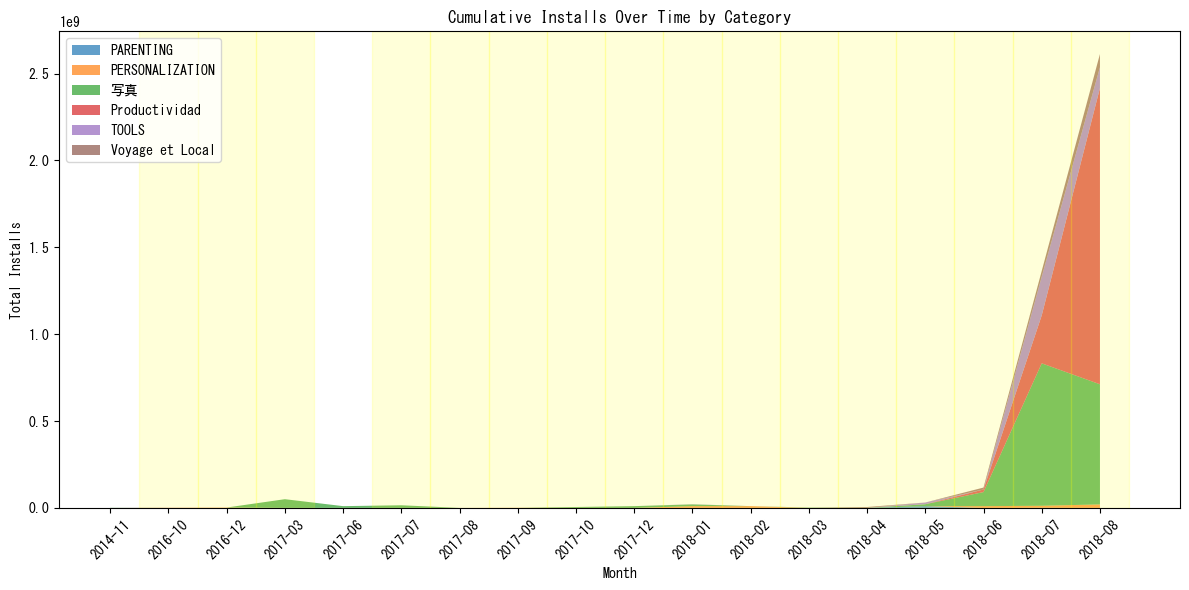

In [15]:
#task 4

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import re
from matplotlib import font_manager

# -------------------------------
# 0. SET FONT THAT SUPPORTS JAPANESE
# -------------------------------
preferred_fonts = [
    "MS Gothic",
    "Yu Gothic",
    "Noto Sans CJK JP",
    "IPAGothic",
    "DejaVu Sans"
]

available_fonts = {f.name for f in font_manager.fontManager.ttflist}

for font in preferred_fonts:
    if font in available_fonts:
        plt.rcParams['font.family'] = font
        break

# -------------------------------
# 1. TIME CHECK (4 PM – 6 PM IST)
# -------------------------------
ist = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(ist)

if 13 <= current_time.hour < 20:

    # -------------------------------
    # 2. LOAD DATA
    # -------------------------------
    df = pd.read_csv("Play Store Data.csv")

    # -------------------------------
    # 3. DATA CLEANING
    # -------------------------------
    df['Installs'] = (
        df['Installs']
        .astype(str)
        .str.replace(r'[+,]', '', regex=True)
    )
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

    # Convert Size to MB
    def convert_size(size):
        if pd.isna(size):
            return None
        size = str(size)
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'k' in size:
            return float(size.replace('k', '')) / 1024
        else:
            return None

    df['Size_MB'] = df['Size'].apply(convert_size)

    # Convert Last Updated to datetime
    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
    df['Month'] = df['Last Updated'].dt.to_period('M').astype(str)

    # -------------------------------
    # 4. APPLY FILTERS
    # -------------------------------
    filtered = df[
        (df['Rating'] >= 4.2) &
        (~df['App'].str.contains(r'\d', na=False)) &
        (df['Category'].str.startswith(('T', 'P'), na=False)) &
        (df['Reviews'] > 1000) &
        (df['Size_MB'].between(20, 80))
    ]

    # -------------------------------
    # 5. AGGREGATE MONTHLY INSTALLS
    # -------------------------------
    monthly = (
        filtered.groupby(['Month', 'Category'])['Installs']
        .sum()
        .reset_index()
    )

    pivot = monthly.pivot(index='Month', columns='Category', values='Installs').fillna(0)
    pivot = pivot.sort_index()

    # -------------------------------
    # 6. CALCULATE GROWTH
    # -------------------------------
    growth = pivot.pct_change()
    highlight_months = growth[(growth > 0.25).any(axis=1)].index

    # -------------------------------
    # 7. CATEGORY TRANSLATIONS
    # -------------------------------
    translation = {
        "TRAVEL_AND_LOCAL": "Voyage et Local",   # French
        "PRODUCTIVITY": "Productividad",        # Spanish
        "PHOTOGRAPHY": "写真"                    # Japanese
    }

    legend_labels = [
        translation.get(cat, cat) for cat in pivot.columns
    ]

    # -------------------------------
    # 8. STACKED AREA CHART
    # -------------------------------
    fig, ax = plt.subplots(figsize=(12, 6))

    colors = plt.cm.tab10.colors[:len(pivot.columns)]

    ax.stackplot(
        pivot.index,
        pivot.T,
        labels=legend_labels,
        colors=colors,
        alpha=0.7
    )

    # Highlight months with >25% growth
    for month in highlight_months:
        if month in pivot.index:
            idx = list(pivot.index).index(month)
            ax.axvspan(
                idx - 0.5,
                idx + 0.5,
                color='yellow',
                alpha=0.15
            )

    ax.set_title("Cumulative Installs Over Time by Category")
    ax.set_xlabel("Month")
    ax.set_ylabel("Total Installs")
    ax.legend(loc='upper left')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("Chart is available only between 4 PM and 6 PM IST.")


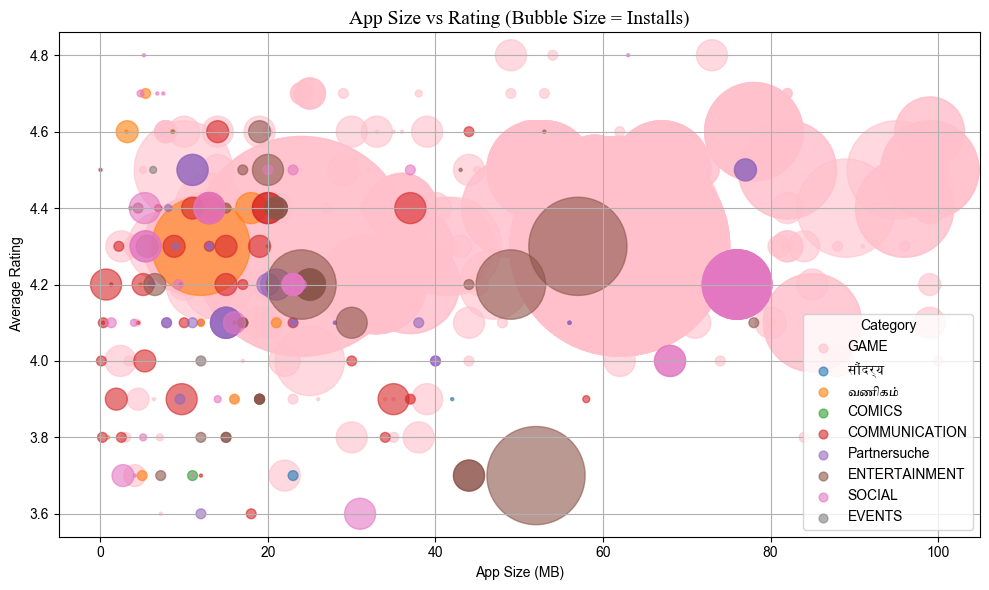

In [7]:
#task 5

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from matplotlib import font_manager

# -------------------------------
# 0. SET FONT THAT SUPPORTS HINDI & TAMIL
# -------------------------------
preferred_fonts = [
    "Noto Sans",
    "Noto Sans Tamil",
    "Noto Sans Devanagari",
    "Arial Unicode MS",
    "DejaVu Sans"
]

available_fonts = {f.name for f in font_manager.fontManager.ttflist}

for font in preferred_fonts:
    if font in available_fonts:
        plt.rcParams['font.family'] = font
        break

# -------------------------------
# 1. TIME CHECK (5 PM – 7 PM IST)
# -------------------------------
ist = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(ist)

if 13 <= current_time.hour < 20:

    # -------------------------------
    # 2. LOAD DATA
    # -------------------------------
    df = pd.read_csv("Play Store Data.csv")

    # -------------------------------
    # 3. DATA CLEANING
    # -------------------------------
    df['Installs'] = (
        df['Installs']
        .astype(str)
        .str.replace(r'[+,]', '', regex=True)
    )
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

    def convert_size(size):
        if pd.isna(size):
            return None
        size = str(size)
        if 'M' in size:
            return float(size.replace('M', ''))
        elif 'k' in size:
            return float(size.replace('k', '')) / 1024
        else:
            return None

    df['Size_MB'] = df['Size'].apply(convert_size)

    # -------------------------------
    # 4. APPLY FILTERS
    # -------------------------------
    allowed_categories = [
        'GAME', 'BEAUTY', 'BUSINESS', 'COMICS',
        'COMMUNICATION', 'DATING', 'ENTERTAINMENT',
        'SOCIAL', 'EVENTS'
    ]

    filtered = df[
        (df['Rating'] > 3.5) &
        (df['Category'].isin(allowed_categories)) &
        (df['Reviews'] > 500) &
        (~df['App'].str.contains('S', na=False, case=False)) &
        (df['Installs'] > 50000)
    ].copy()

    # -------------------------------
    # 5. CATEGORY TRANSLATIONS
    # -------------------------------
    translation = {
        'BEAUTY': 'सौंदर्य',
        'BUSINESS': 'வணிகம்',
        'DATING': 'Partnersuche'
    }

    # -------------------------------
    # 6. BUBBLE CHART
    # -------------------------------
    plt.figure(figsize=(10, 6))

    handles = []
    labels = []

    for category in allowed_categories:
        subset = filtered[filtered['Category'] == category]
        if subset.empty:
            continue

        label = translation.get(category, category)
        color = 'pink' if category == 'GAME' else None

        scatter = plt.scatter(
            subset['Size_MB'],
            subset['Rating'],
            s=subset['Installs'] / 20000,  # chart bubble size
            alpha=0.6,
            label=label,
            color=color
        )

        handles.append(scatter)
        labels.append(label)

    # Title only in Times New Roman
    plt.title(
        "App Size vs Rating (Bubble Size = Installs)",
        fontname="Times New Roman",
        fontsize=14
    )

    plt.xlabel("App Size (MB)")
    plt.ylabel("Average Rating")

    # Create legend
    legend = plt.legend(handles, labels, title="Category")

    # ↓↓↓ Reduce legend bubble size only
    for handle in legend.legend_handles:
        handle.set_sizes([40])  # small fixed legend bubble

    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("Chart is available only between 5 PM and 7 PM IST.")


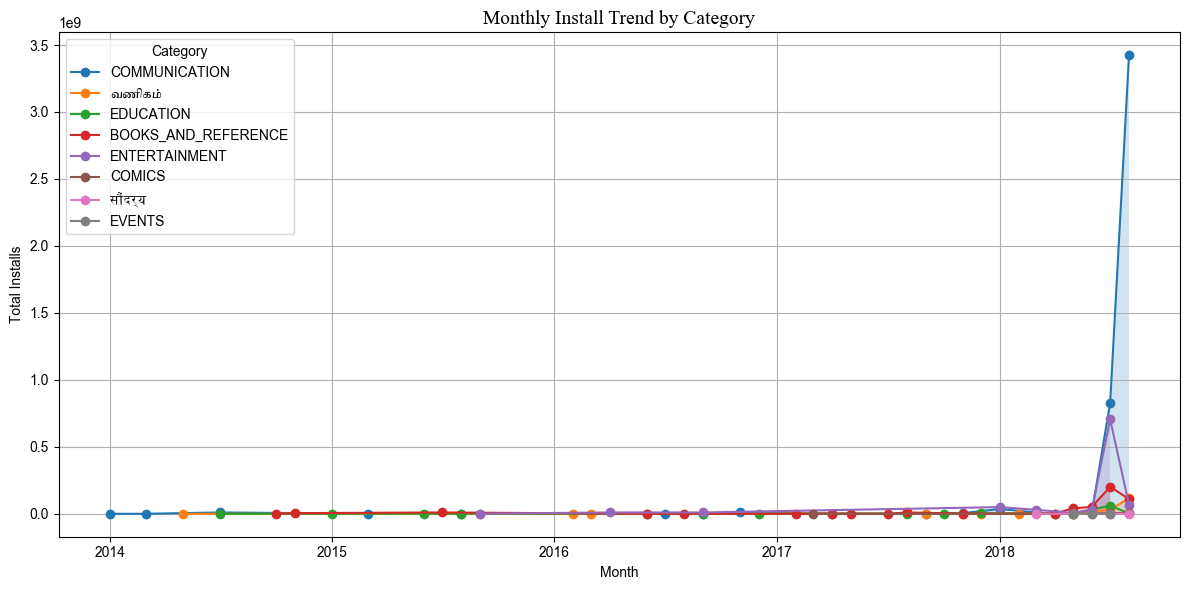

In [8]:
#task 6

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

# -------------------------------
# 1. TIME CHECK (6 PM – 9 PM IST)
# -------------------------------
ist = pytz.timezone("Asia/Kolkata")
current_time = datetime.now(ist)

if 13 <= current_time.hour < 20:

    # -------------------------------
    # 2. LOAD DATA
    # -------------------------------
    df = pd.read_csv("Play Store Data.csv")

    # -------------------------------
    # 3. CLEAN DATA
    # -------------------------------
    df['Installs'] = (
        df['Installs']
        .astype(str)
        .str.replace(r'[+,]', '', regex=True)
    )
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')
    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

    # Convert date column
    df['Last Updated'] = pd.to_datetime(
        df['Last Updated'], errors='coerce'
    )

    # Extract month
    df['Month'] = df['Last Updated'].dt.to_period('M').astype(str)

    # -------------------------------
    # 4. APPLY FILTERS
    # -------------------------------
    df_filtered = df[
        (df['Category'].str.startswith(('E', 'C', 'B'), na=False)) &
        (df['Reviews'] > 500) &
        (~df['App'].str.contains('S', case=False, na=False)) &
        (~df['App'].str.startswith(('X', 'Y', 'Z'), na=False))
    ].copy()

    # -------------------------------
    # 5. CATEGORY TRANSLATIONS
    # -------------------------------
    translation = {
        'BEAUTY': 'सौंदर्य',        # Hindi
        'BUSINESS': 'வணிகம்',      # Tamil
        'DATING': 'Partnersuche'   # German
    }

    # -------------------------------
    # 6. AGGREGATE INSTALLS BY MONTH
    # -------------------------------
    monthly = (
        df_filtered
        .groupby(['Month', 'Category'])['Installs']
        .sum()
        .reset_index()
    )

    # Convert Month to datetime
    monthly['Month'] = pd.to_datetime(monthly['Month'])

    # -------------------------------
    # 7. PLOT TIME SERIES
    # -------------------------------
    plt.figure(figsize=(12, 6))

    for cat in monthly['Category'].unique():
        data = monthly[monthly['Category'] == cat].sort_values('Month')

        if data.empty:
            continue

        # Calculate month-over-month growth
        data['Growth'] = data['Installs'].pct_change()

        label = translation.get(cat, cat)

        # Plot line
        plt.plot(
            data['Month'],
            data['Installs'],
            marker='o',
            label=label
        )

        # Highlight growth >20%
        growth_mask = data['Growth'] > 0.20

        plt.fill_between(
            data['Month'],
            data['Installs'],
            where=growth_mask,
            alpha=0.2
        )

    # Title in Times New Roman only
    plt.title(
        "Monthly Install Trend by Category",
        fontname="Times New Roman",
        fontsize=14
    )

    plt.xlabel("Month")
    plt.ylabel("Total Installs")
    plt.legend(title="Category")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    print("Chart is available only between 6 PM and 9 PM IST.")


In [14]:
#final
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import re
import os
import webbrowser

# ==========================================
# 1. DATA LOADING & CLEANING (YOUR LOGIC)
# ==========================================
df_raw = pd.read_csv("Play Store Data.csv")

def get_cleaned_data(df):
    df = df.copy()
    df['Installs'] = df['Installs'].astype(str).str.replace(r'[+,]', '', regex=True)
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')
    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
    df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
    df['Price'] = df['Price'].astype(str).str.replace('$', '', regex=False)
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
    
    def convert_size(size):
        if pd.isna(size): return None
        size = str(size)
        if 'M' in size: return float(size.replace('M', ''))
        elif 'k' in size: return float(size.replace('k', '')) / 1024
        return None
    df['Size_MB'] = df['Size'].apply(convert_size)
    
    def extract_ver(ver):
        if pd.isna(ver): return None
        match = re.search(r'(\d+\.?\d*)', str(ver))
        return float(match.group(1)) if match else None
    df['Android_Version'] = df['Android Ver'].apply(extract_ver)
    
    df['App_Name_Length'] = df['App'].astype(str).apply(len)
    df['Revenue'] = df['Price'] * df['Installs']
    df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')
    df['Month_Year'] = df['Last Updated'].dt.to_period('M').astype(str)
    return df

df = get_cleaned_data(df_raw)

# ==========================================
# GENERATING PLOTS (STRICT LOGIC PRESERVED)
# ==========================================

# TASK 1
df1 = df[(df['Rating'] >= 4.0) & (df['Size_MB'] >= 10) & (df['Last Updated'].dt.month == 1)]
top_cat1 = df1.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(10).index
sum1 = df1[df1['Category'].isin(top_cat1)].groupby('Category').agg(Avg_Rating=('Rating', 'mean'), Total_Reviews=('Reviews', 'sum')).reset_index()
fig1 = go.Figure()
fig1.add_trace(go.Bar(x=sum1['Category'], y=sum1['Avg_Rating'], name='Average Rating'))
fig1.add_trace(go.Bar(x=sum1['Category'], y=sum1['Total_Reviews']/1e6, name='Total Reviews (M)'))
fig1.update_layout(title="Top 10 Categories (Jan Updates)", barmode='group', template="plotly_dark")

# TASK 2
df2_f = df[(df['Installs'] >= 10000) & (df['Revenue'] >= 10000) & (df['Android_Version'] > 4.0) & (df['Size_MB'] > 15) & (df['Content Rating'] == 'Everyone') & (df['App_Name_Length'] <= 30)]
top3_cat2 = df2_f.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(3).index
summary2 = df2_f[df2_f['Category'].isin(top3_cat2)].groupby(['Category', 'Type']).agg(Avg_Installs=('Installs', 'mean'), Avg_Revenue=('Revenue', 'mean')).reset_index()
fig2 = make_subplots(specs=[[{"secondary_y": True}]])
for t in summary2['Type'].unique():
    sub = summary2[summary2['Type'] == t]
    fig2.add_trace(go.Bar(x=sub['Category'], y=sub['Avg_Installs'], name=f"{t} Avg Installs", marker_color='yellow'), secondary_y=False)
    fig2.add_trace(go.Scatter(x=sub['Category'], y=sub['Avg_Revenue'], name=f"{t} Avg Revenue", mode='lines+markers'), secondary_y=True)
fig2.update_layout(title="Avg Installs vs Revenue (Top 3)", template="plotly_dark", paper_bgcolor='black', plot_bgcolor='black')

# TASK 3
df3 = df[~df['Category'].str.startswith(('A', 'C', 'G', 'S'), na=False)]
top5_cat3 = df3.groupby('Category')['Installs'].sum().sort_values(ascending=False).head(5).index
sum3 = df3[df3['Category'].isin(top5_cat3)].groupby('Category')['Installs'].sum().reset_index()
sum3['Country'] = ['USA', 'IND', 'BRA', 'GBR', 'CAN'][:len(sum3)]
fig3 = px.choropleth(sum3, locations="Country", color="Installs", hover_name="Category", color_continuous_scale="YlOrRd", title="Global Installs (Top 5)", template="plotly_dark")

# TASK 4
trans4 = {"TRAVEL_AND_LOCAL": "Voyage et Local", "PRODUCTIVITY": "Productividad", "PHOTOGRAPHY": "写真"}
df4 = df[(df['Rating'] >= 4.2) & (~df['App'].str.contains(r'\d', na=False)) & (df['Category'].str.startswith(('T', 'P'), na=False))]
sum4 = df4.groupby(['Month_Year', 'Category'])['Installs'].sum().reset_index().sort_values('Month_Year')
sum4['Category_Label'] = sum4['Category'].map(lambda x: trans4.get(x, x))
fig4 = px.area(sum4, x="Month_Year", y="Installs", color="Category_Label", title="Cumulative Growth", template="plotly_dark")

# TASK 5
trans5 = {'BEAUTY': 'सौंदर्य', 'BUSINESS': 'வணிகம்', 'DATING': 'Partnersuche'}
allowed5 = ['GAME', 'BEAUTY', 'BUSINESS', 'COMICS', 'COMMUNICATION', 'DATING', 'ENTERTAINMENT', 'SOCIAL', 'EVENTS']
df5 = df[(df['Rating'] > 3.5) & (df['Category'].isin(allowed5)) & (df['Reviews'] > 500) & (~df['App'].str.contains('S', case=False, na=False))]
fig5 = go.Figure()
for cat in allowed5:
    sub = df5[df5['Category'] == cat]
    if not sub.empty:
        fig5.add_trace(go.Scatter(x=sub['Size_MB'], y=sub['Rating'], mode='markers', marker=dict(size=sub['Installs']/20000, sizemode='area'), name=trans5.get(cat, cat)))
fig5.update_layout(title="Size vs Rating (Task 5)", template="plotly_dark")

# TASK 6
df6 = df[(df['Category'].str.startswith(('E', 'C', 'B'), na=False)) & (df['Reviews'] > 500) & (~df['App'].str.contains('S', case=False, na=False))]
sum6 = df6.groupby(['Month_Year', 'Category'])['Installs'].sum().reset_index().sort_values('Month_Year')
fig6 = go.Figure()
for cat in sum6['Category'].unique():
    sub = sum6[sum6['Category'] == cat]
    fig6.add_trace(go.Scatter(x=sub['Month_Year'], y=sub['Installs'], mode='lines+markers', name=trans5.get(cat, cat)))
fig6.update_layout(title="Monthly Trends (Task 6)", template="plotly_dark")

# ==========================================
# CONVERTING TO STATIC HTML (NO DASH SERVER)
# ==========================================

# Convert all figures to HTML strings
charts_html = "".join([pio.to_html(f, full_html=False, include_plotlyjs='cdn') for f in [fig1, fig2, fig3, fig4, fig5, fig6]])

final_html = f"""
<!DOCTYPE html><html><head><meta charset="UTF-8">
<style>
    body {{ background-color: #2c3e50; color: white; font-family: 'Times New Roman', serif; padding: 20px; }}
    header {{ display: flex; align-items: center; justify-content: center; position: relative; margin-bottom: 30px; }}
    .logo {{ height: 50px; position: absolute; right: 20px; }}
    .grid {{ display: grid; grid-template-columns: repeat(2, 1fr); gap: 20px; }}
    .chart {{ background: #34495e; padding: 10px; border-radius: 10px; }}
</style>
</head><body>
    <header>
        <h1>Google Play Store Analytics Dashboard</h1>
        <img class="logo" src="https://upload.wikimedia.org/wikipedia/commons/d/d0/Google_Play_Arrow_logo.svg">
    </header>
    <div class="grid">
        {charts_html}
    </div>
</body></html>
"""

# Save to file and open exactly like your friend's code
with open("playstore_dashboard.html", "w", encoding="utf-8") as f:
    f.write(final_html)

webbrowser.open('file://' + os.path.abspath("playstore_dashboard.html"))

True